# Visualize gene expression

This notebook visualizes the trends in gene expression data for the template and simulated experiments

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

In [2]:
import os
import pandas as pd

from ponyo import utils
from generic_expression_patterns_modules import plot

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Load config parameters

In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_17179.tsv")
)

params = utils.read_config(config_filename)

In [4]:
# Load config params
local_dir = params['local_dir']
dataset_name = params['dataset_name']
project_id = params['project_id']
num_simulated = params['num_simulated']

pval_name = "adj.P.Val"
logFC_name = "logFC"

gene_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_gene_summary_{project_id}.tsv"
)

## Volcano plots

In [5]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats[pval_name]<0.01) & (abs(template_DE_stats[logFC_name])>1)]
print(selected.shape)

(35, 6)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


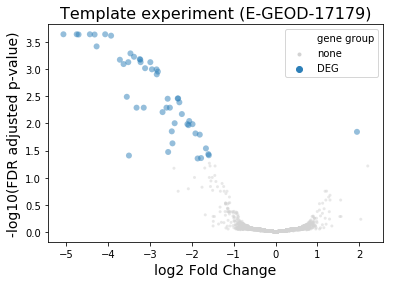

In [6]:
plot.make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
    pval_name,
    logFC_name
)

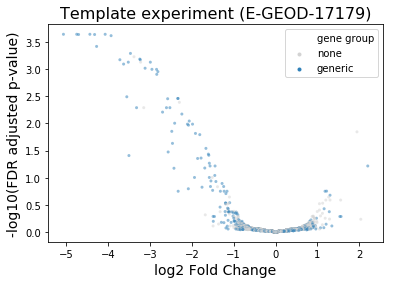

In [7]:
plot.make_volcano_plot_template_highlight(
    gene_summary_filename,
    4500,
    template_DE_stats_filename,
    project_id,
    pval_name,
    logFC_name,
    os.path.join(local_dir,f"template_volcano_{project_id}.svg")
)

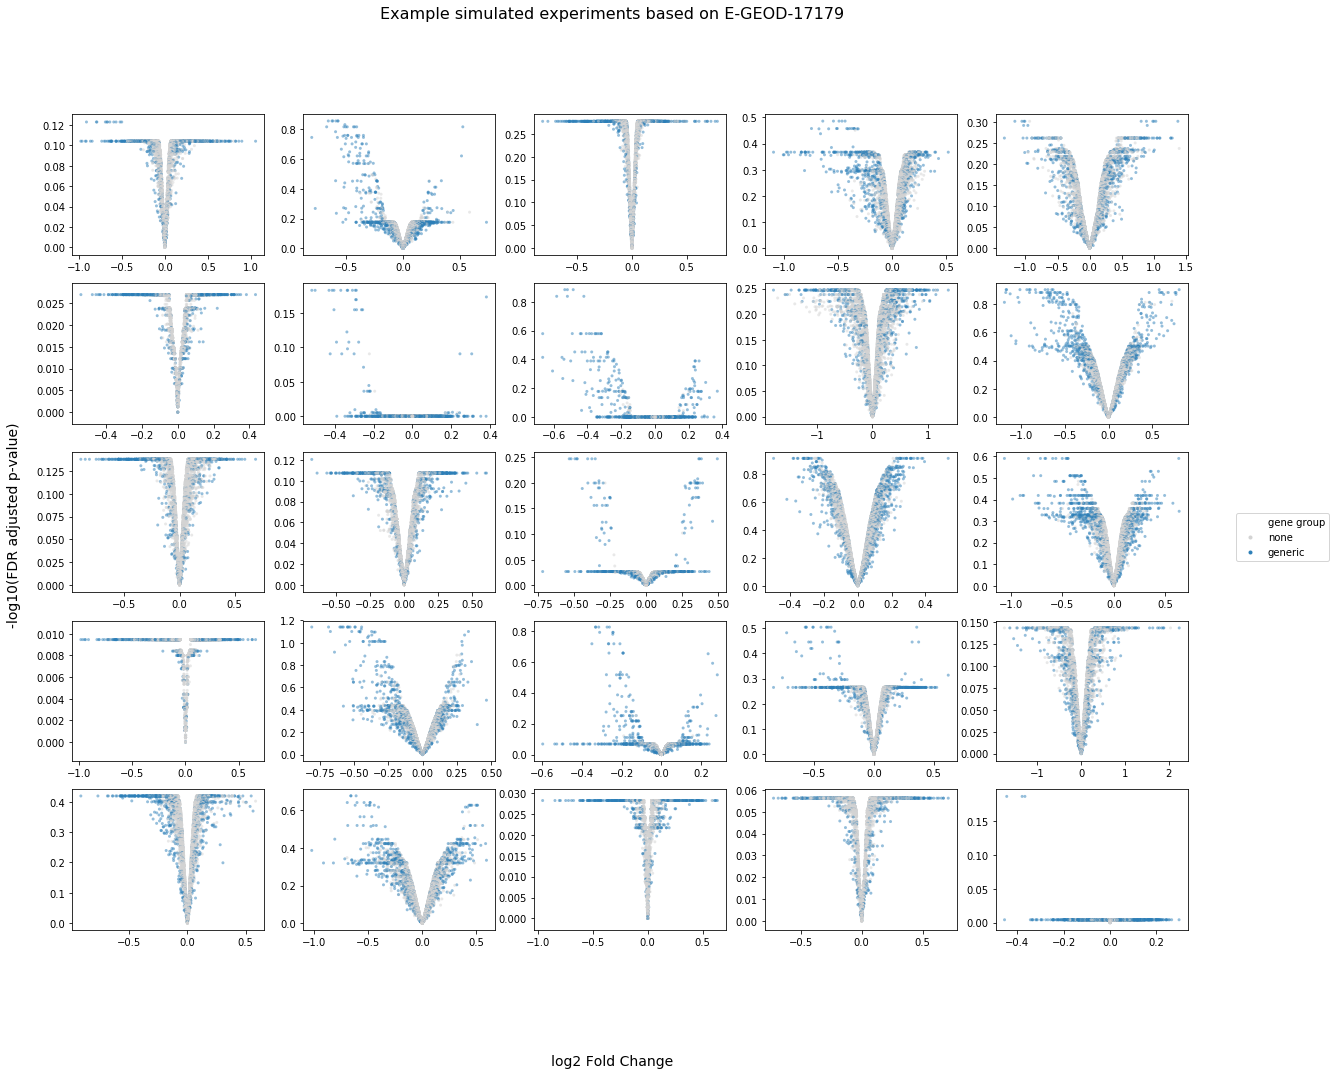

In [8]:
simulated_DE_stats_dir = os.path.join(local_dir, "DE_stats")

plot.make_volcano_plot_simulated_highlight(
    gene_summary_filename,
    4500,
    simulated_DE_stats_dir,
    project_id,
    pval_name,
    logFC_name,
    num_simulated,
    5,
    5,
    20,
    15,
    os.path.join(local_dir,f"simulated_volcano_{project_id}.svg")
)

**Takeaway:**

These highlighted volcano plots demonstrate that the generic gense are found to be highly DE (based on logFC) across all simulated experiments. 